# Hands-on Tutorial: Measuring Unintended Bias in Text Classification Models with Real Data

## Usage Instructions

Prior to running the notebook, you must:

* Install all Python dependencies from the `requirements.txt` file
* Download all training, validation, and test files

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pandas as pd
import numpy as np
import pkg_resources
import matplotlib.pyplot as plt
import seaborn as sns
import time
import scipy.stats as stats

from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding
from keras.layers import Input
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Dense
from keras.optimizers import RMSprop
from keras.models import Model

%matplotlib inline

# autoreload makes it easier to interactively work on code in imported libraries
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


## Load and pre-process data sets

In [2]:
# These files will be provided to tutorial participants via Google Cloud Storage
train_df = pd.read_csv('../data/fat_star_tutorial/public_train.csv')
validate_df = pd.read_csv('../data/fat_star_tutorial/public_validate.csv')
test_df = pd.read_csv('../data/fat_star_tutorial/public_test.csv')

Let's examine some rows in these datasets.  Note that columns like toxicity and male are percent scores.
We query for "male >= 0" to exclude rows where the male identity is not labeled.

In [3]:
train_df[['toxicity', 'male', 'comment_text']].query('male >= 0').head()

,toxicity,male,comment_text
4986,0.757143,0.0,Why is this black racist crap still on the G&M...
4987,0.688525,0.0,even up here.......BLACKS!
4988,0.545455,1.0,Blame men. There's always an excuse to blame ...
4989,0.728571,0.0,And the woman exposing herself saying grab thi...
4990,0.594595,0.0,You have no business making any comments on th...


We will need to convert toxicity and identity columns to booleans, in order to work with our neural net and metrics calculcations.  For this tutorial, we will consider any value >= 0.5 as True (i.e. a comment should be considered toxic if 50% or more crowd raters labeled it as toxic).  Note that this code also converts missing identity fields to False.

In [4]:
# List all identities
identity_columns = ['male', 'female', 'transgender', 'other_gender', 'heterosexual', 'homosexual_gay_or_lesbian', 'bisexual', 'other_sexual_orientation', 'christian', 'jewish', 'muslim', 'hindu', 'buddhist', 'atheist', 'other_religion', 'black', 'white', 'asian', 'latino', 'other_race_or_ethnicity', 'physical_disability', 'intellectual_or_learning_disability', 'psychiatric_or_mental_illness', 'other_disability']

def convert_to_bool(df, col_name):
    df[col_name] = np.where(df[col_name] >= 0.5, True, False)

for df in [train_df, validate_df, test_df]:
    for col in ['toxicity'] + identity_columns:
        convert_to_bool(df, col)
    
train_df[['toxicity', 'male', 'comment_text']].head()

,toxicity,male,comment_text
0,False,False,He got his money... now he lies in wait till a...
1,True,False,Mad dog will surely put the liberals in mental...
2,True,False,And Trump continues his lifelong cowardice by ...
3,False,False,"Cry me a river, why don't you.\nDrinking, drug..."
4,True,False,That's right. They are not normal. And I am st...


## Create and Train Models

This code creates and trains a convolutional neural net using the Keras framework.  This neural net accepts a text comment, encoding as a sequence of integers, and outputs a probably that the comment is toxic.  Don't worry if you do not understand all of this code, as we will be treating this neural net as a black box later in the tutorial.

In [17]:
MAX_SEQUENCE_LENGTH = 250
MAX_NUM_WORDS = 10000
TOXICITY_COLUMN = 'toxicity'
TEXT_COLUMN = 'comment_text'
MODEL_NAME_V1 = 'fat_star_tutorial_v1'
EMBEDDINGS_PATH = '../data/glove.6B/glove.6B.100d.txt'
EMBEDDINGS_DIMENSION = 100
DROPOUT_RATE = 0.3
LEARNING_RATE = 0.00005
NUM_EPOCHS = 4
BATCH_SIZE = 128

In [18]:
# Fit tokenizer
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(train_df[TEXT_COLUMN])

In [19]:
# Prepare data
def pad_text(texts):
    return pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=MAX_SEQUENCE_LENGTH)
train_text = pad_text(train_df[TEXT_COLUMN])
train_labels = to_categorical(train_df[TOXICITY_COLUMN])
validate_text = pad_text(validate_df[TEXT_COLUMN])
validate_labels = to_categorical(validate_df[TOXICITY_COLUMN])

In [20]:
# Load embeddings
embeddings_index = {}
with open(EMBEDDINGS_PATH) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((len(tokenizer.word_index) + 1,
                             EMBEDDINGS_DIMENSION))
num_words_in_embedding = 0
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        num_words_in_embedding += 1
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [21]:
# Create model layers.
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(len(tokenizer.word_index) + 1,
                            EMBEDDINGS_DIMENSION,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
x = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu', padding='same')(x)
x = MaxPooling1D(5, padding='same')(x)
x = Conv1D(128, 5, activation='relu', padding='same')(x)
x = MaxPooling1D(5, padding='same')(x)
x = Conv1D(128, 5, activation='relu', padding='same')(x)
x = MaxPooling1D(40, padding='same')(x)
x = Flatten()(x)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(128, activation='relu')(x)
preds = Dense(2, activation='softmax')(x)

# Compile model.
model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=LEARNING_RATE),
              metrics=['acc'])

# Train model.
model.fit(train_text,
          train_labels,
          batch_size=BATCH_SIZE,
          epochs=NUM_EPOCHS,
          validation_data=(validate_text, validate_labels),
          callbacks=[],   # TODO: add callbacks?
          verbose=2)

Train on 1289508 samples, validate on 161193 samples
Epoch 1/4
1128s - loss: 0.2051 - acc: 0.9294 - val_loss: 0.1772 - val_acc: 0.9386
Epoch 2/4
1141s - loss: 0.1685 - acc: 0.9403 - val_loss: 0.1679 - val_acc: 0.9403
Epoch 3/4
1121s - loss: 0.1603 - acc: 0.9432 - val_loss: 0.1590 - val_acc: 0.9435
Epoch 4/4
1180s - loss: 0.1553 - acc: 0.9445 - val_loss: 0.1629 - val_acc: 0.9434


## Score test set with the new model

Using our new model, we can score the set of test comments for toxicity.

In [ ]:
test_comments_padded = pad_text(test_df[TEXT_COLUMN])
test_df[MODEL_NAME_V1] = model.predict(test_comments_padded)[:, 1]
# Write the scored comments to a file, this will help us analyze them again
# later on, without needing to rebuild our model.
test_df.to_csv('../data/fat_star_tutorial/public_test_scored.csv')

In [ ]:
# Print some records to compare our model resulsts with the correct labels
test_df[[TOXICITY_COLUMN, TEXT_COLUMN, MODEL_NAME_V1]].head(10)

## Measure bias

Using metrics based on Pinned AUC and the Mann Whitney U test, we can measure our model for biases against different identity groups.  We only calculate bias metrics on identities that are refered to in 100 or more comments, to minimize noise.

In [24]:
# Get a list of identity columns that have >= 100 True records.  This will remove groups such
# as "other_disability" which do not have enough records to calculate meaningful metrics.
identities_with_over_100_records = []
for identity in identity_columns:
    num_records = len(test_df.query(identity + '==True'))
    if num_records >= 100:
        identities_with_over_100_records.append(identity)

In [25]:
def compute_normalized_pinned_auc(df, subgroup, model_name):
    subgroup_non_toxic = df[df[subgroup] & ~df[TOXICITY_COLUMN]]
    subgroup_toxic = df[df[subgroup] & df[TOXICITY_COLUMN]]
    background_non_toxic = df[~df[subgroup] & ~df[TOXICITY_COLUMN]]
    background_toxic = df[~df[subgroup] & df[TOXICITY_COLUMN]]
    
    within_subgroup_mwu = normalized_mwu(subgroup_non_toxic, subgroup_toxic, model_name)
    cross_negative_mwu = normalized_mwu(subgroup_non_toxic, background_toxic, model_name)
    cross_positive_mwu = normalized_mwu(background_non_toxic, subgroup_toxic, model_name)
    
    return np.mean([1 - within_subgroup_mwu, 1 - cross_negative_mwu, 1 - cross_positive_mwu])

def normalized_mwu(data1, data2, model_name):
    """Returns the number of pairs where the datapoint in data1 has a greater score than that from data2.""" 
    scores_1 = data1[model_name]
    scores_2 = data2[model_name]
    n1 = len(scores_1)
    n2 = len(scores_2)
    u, _ = stats.mannwhitneyu(scores_1, scores_2, alternative = 'less')
    return u/(n1*n2)

bias_metrics_df = pd.DataFrame({
    'subgroup': identities_with_over_100_records,
    'normalized_pinned_auc': [compute_normalized_pinned_auc(test_df, identity, MODEL_NAME_V1)
                              for identity in identities_with_over_100_records]
})

# Re-order columns and sort bias metrics
bias_metrics_df = bias_metrics_df[['subgroup', 'normalized_pinned_auc']].sort_values('normalized_pinned_auc')
bias_metrics_df

,subgroup,normalized_pinned_auc
2,transgender,0.824415
4,homosexual_gay_or_lesbian,0.829740
3,heterosexual,0.836599
9,black,0.838990
10,white,0.844949
7,muslim,0.848659
6,jewish,0.863280
1,female,0.881339
13,psychiatric_or_mental_illness,0.882283
12,latino,0.887499


We can graph a histogram of comment scores in each identity.  In the following graphs, the X axis represents the toxicity score given by our new model, and the Y axis represents the comment count.  Blue values are comment whose true label is non-toxic, while red values are those whose true label is toxic.

We can see that for some identities such as Asian, the model scores most non-toxic comments as less than 0.2 and most toxic comments as greater than 0.2.  This indicates that for the Asian identity, our model is able to distinguish between toxic and non-toxic comments.  However, for the black identity, there are many non-toxic comments with scores over 0.5, along with many toxic comments with scores of less than 0.5.  This shows that for the black identity, our model will be less accurate at separating toxic comments from non-toxic comments.

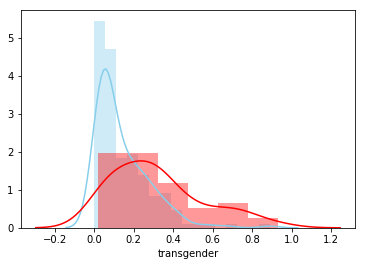

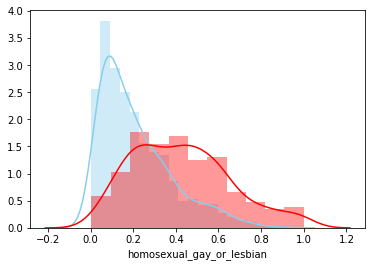

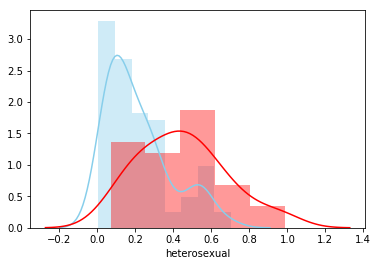

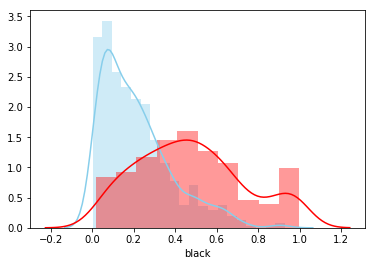

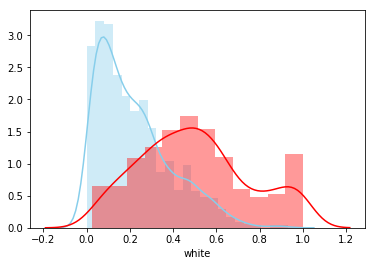

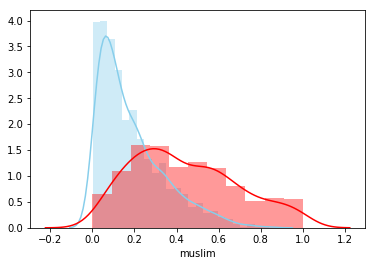

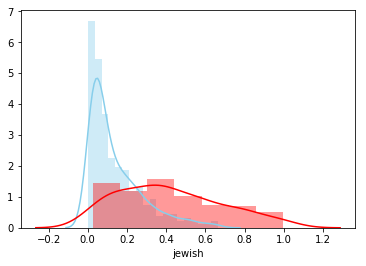

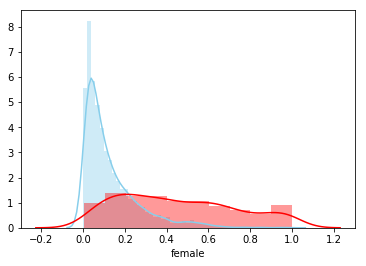

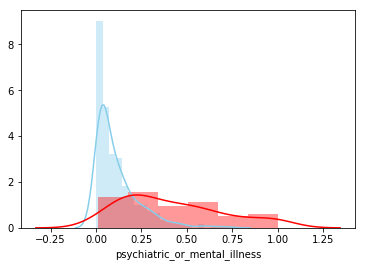

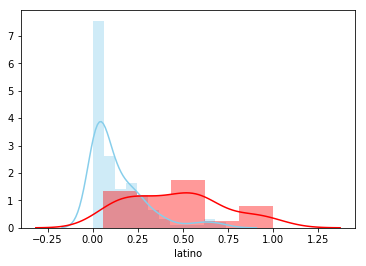

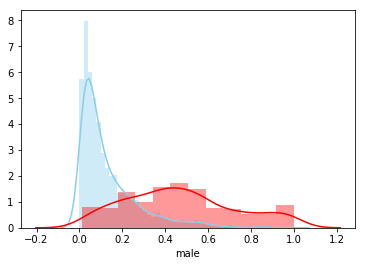

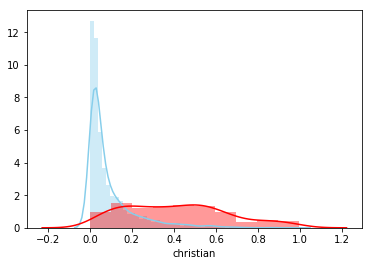

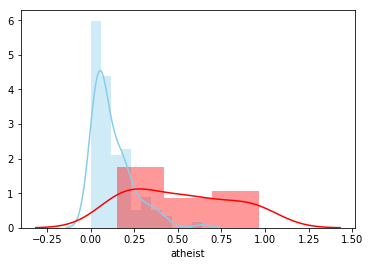

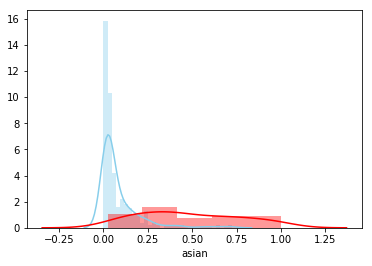

In [27]:
# Plot toxicity distributions of different identities to visualize bias.
def plot_histogram(identity):
    toxic_scores = test_df.query(identity + ' == True & toxicity == True')[MODEL_NAME_V1]
    non_toxic_scores = test_df.query(identity + ' == True & toxicity == False')[MODEL_NAME_V1]
    sns.distplot(non_toxic_scores, color="skyblue", axlabel=identity)
    sns.distplot(toxic_scores, color="red", axlabel=identity)
    plt.figure()

for identity in bias_metrics_df['subgroup']:
    plot_histogram(identity)